In [1]:
import tensorflow as tf
from tensorflow import keras 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from datetime import datetime

In [2]:
# suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
df = pd.read_csv("commodity_historical.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   780 non-null    object 
 1   Crude Oil Brent Price  780 non-null    float64
 2   Cocoa Price            780 non-null    float64
 3   Gold Price             780 non-null    float64
dtypes: float64(3), object(1)
memory usage: 24.5+ KB


In [4]:
data = df[["date", "Crude Oil Brent Price"]]
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   780 non-null    object 
 1   Crude Oil Brent Price  780 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.3+ KB


In [5]:
data['date'] = pd.to_datetime(data['date'])

/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_18987/736794659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


In [6]:
data = data[data["date"] >= "1980-01-01"]  # instead of 1960 which is statistically insignificant

In [7]:
import plotly.express as px
import plotly.graph_objects as go


def plotting(title, data, x, y, x_label, y_label, text=False, lam=None):
    """General function to plot the data."""
    fig = px.line(data, x=data[x], y=data[y], labels={x: x_label, y: y_label})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title, width=650, title_x=0.5, height=400)
    if text:
      fig.add_annotation(
          x='1952-12-20', y=10, text=f'Lambda = {lam:.3f}',
          align='left', yanchor='bottom', showarrow=False,
          font=dict(size=20, color="black", family="Courier New, monospace"),
          bordercolor='black', borderwidth=2, bgcolor="white"
      )
    fig.show()


def add_separator(width=650):
    """Add a horizontal line as a separator."""
    fig = go.Figure()
    fig.add_hline(y=0.5, line_dash="dot", line_color="gray", line_width=2)
    fig.update_layout(height=50, width=width, margin=dict(l=20, r=20, t=20, b=20), xaxis_visible=False, yaxis_visible=False)
    fig.show()


In [8]:
plotting(title='Crude Oil Brent Over Time', data=data, x='date', y='Crude Oil Brent Price', x_label='Date', y_label='Price ($/bbl)')
# add_separator()

In [9]:
len(data)

540

In [10]:
train = data.iloc[:528]  # 1980 to 2023
test = data.iloc[528:]  # 2024

In [11]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data["Crude Oil Brent Price"])
scaler.fit(train[["Crude Oil Brent Price"]])
scaled_train = scaler.transform(train[["Crude Oil Brent Price"]])
scaled_test = scaler.transform(test[["Crude Oil Brent Price"]])

In [12]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Define Parameters
lookback = 3  # Number of past steps to use as input
batch_size = 2  # Number of samples per batch
n_features = 1

from tensorflow.keras.utils import timeseries_dataset_from_array

generator = timeseries_dataset_from_array(
    data=scaled_train,
    targets=scaled_train,
    sequence_length=lookback,
    batch_size=batch_size,
)

# Initialize Generator
# generator = TimeseriesGenerator(scaled_train, scaled_train, length=lookback, batch_size=batch_size)

In [13]:
# Build model
model = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=False, input_shape=(lookback, n_features)),  # 1st layer
    # keras.layers.LSTM(127, return_sequences=False),  # 2nd layer
    # keras.layers.Dense(128, activation="relu"),  # 3rd Layer (Dense)
    # keras.layers.Dropout(0.2),  # 4th Layer (Dropout)
    keras.layers.Dense(1)  # Final Output Layer
])

# model summary
model.summary()

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer="adam", 
    loss=keras.losses.MeanSquaredError(), 
    metrics=[keras.metrics.MeanAbsoluteError()]
)

In [15]:
# fit model
model.fit(generator, epochs=50)

Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0047 - mean_absolute_percentage_error: 282004.9375
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5542e-04 - mean_absolute_percentage_error: 120707.0156
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - mean_absolute_percentage_error: 117366.7656
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - mean_absolute_percentage_error: 31512.8926
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.9434e-04 - mean_absolute_percentage_error: 21703.2051
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3397e-04 - mean_absolute_percentage_error: 37839.2852
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4749e-04 - mean_absolute_percentage_error: 66616.1797
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3925e-04 - mean_absolute_percentage_error: 83399.1953
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9132e-04 - mean_abs

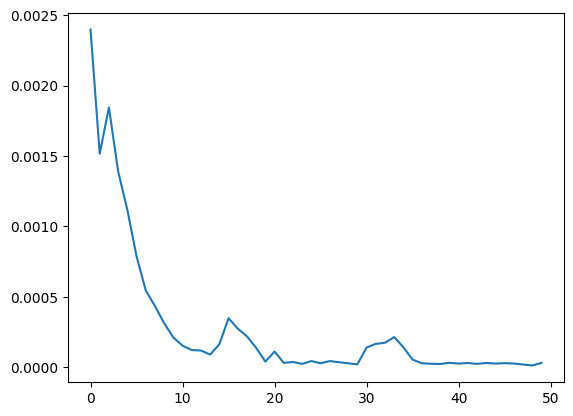

In [16]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [17]:
test_predictions = []

first_eval_batch = scaled_train[-lookback:]
current_batch = first_eval_batch.reshape((1, lookback, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)



# Create a sequence that includes the end of training data + test data
# This allows us to make predictions for the full test set
# input_sequence = np.vstack([scaled_train[-lookback:], scaled_test])

# # Initialize predictions array
# test_predictions = []

# # For each point in the test set
# for i in range(len(scaled_test)):
#     # Extract the current window (LOOKBACK previous points)
#     current_window = input_sequence[i:i+lookback].reshape(1, lookback, n_features)
    
#     # Generate prediction for the next point
#     pred = model.predict(current_window)[0]
#     test_predictions.append(pred)


# # Initialize with the last `lookback` values from the training data
# current_window = scaled_train[-lookback:].reshape(1, lookback, n_features)
# test_predictions = []

# for i in range(len(scaled_test)):
#     # Predict the next value
#     pred = model.predict(current_window, verbose=0)[0]
#     test_predictions.append(pred)
    
#     # Reshape the prediction to (1, 1, n_features) and update the window
#     pred_reshaped = pred.reshape(1, 1, n_features)
#     current_window = np.concatenate(
#         [current_window[:, 1:, :], pred_reshaped], 
#         axis=1
#     )


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [18]:
def plot_forecasts(df: pd.DataFrame, forecasts: np.ndarray, col: str, title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    
    # Plot true values
    fig.add_trace(go.Scatter(x=df['date'], y=df[col], name='Truth', mode='lines'))
    
    # Plot predicted values
    fig.add_trace(go.Scatter(x=df['date'], y=forecasts.flatten(), name='Prediction', mode='lines'))
    
    fig.update_layout(
        template="simple_white", font=dict(size=18), title_text=title,
        width=650, title_x=0.5, height=400, xaxis_title='Date', yaxis_title='Price'
    )
    
    fig.show()

In [19]:
# Ensure test predictions is a 2D NumPy array before inverse scaling
true_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))

# Extract correct test set dates
test_dates = data['date'].iloc[len(train):]

In [20]:
plot_forecasts(
    pd.DataFrame({
        'date': test_dates, 
        "Crude Oil Brent Price": test["Crude Oil Brent Price"].values
    }), 
    true_predictions, 
    "Crude Oil Brent Price", 
    "LSTM Forecast for CrudeOil"
)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Crude Oil Brent Price'], true_predictions))
print(f'rmse: {rmse:.2f}')

rmse: 6.79


In [22]:
mape = mean_absolute_percentage_error(test['Crude Oil Brent Price'], true_predictions)
print(f'mape: {mape*100:.2f}%')

mape: 6.73%


In [23]:
mae = mean_absolute_error(test['Crude Oil Brent Price'], true_predictions)
print(f'mae: {mae:.2f}')

mae: 5.31


In [ ]:
model.save("saved_models/crudeoil_lstm_model.keras")